In [1]:
import torch

torch.cuda.is_available()

True

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [1]:
!wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-512x512.pkl -O stylegan2-ffhq-512x512.pkl
!wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-256x256.pkl -O stylegan3-r-ffhqu-256x256.pkl

--2024-05-20 13:09:09--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-512x512.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 52.89.224.217, 54.201.20.7
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|52.89.224.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://files.ngc.nvidia.com/org/nvidia/team/research/models/stylegan2/versions/1/files/stylegan2-ffhq-512x512.pkl?versionId%3DPgUqAXxvpc6n4kP.aj5CUKTur7PTLDif&Expires=1716289749&Signature=WrfzfshhCEIOMUS8nY0mTXbmX12d4qEOy1C4y7F8ygFtjUbK2kRI5AiOHAxZi07keK6XqW80y5ISpFv~A0L2D2LPyZX8-V~r6HgG5cr5zHs1iegEln7PAcX22DivNY7kFpP4yCYZYvlmRzXuUaWS3INTrKiV-kgc5-~uxOfJTD1oa2-FAUk6pfHRyGTgT5o-2dZl~pEPb06dyuApN-RGGuZVDVMbsXmzCk~4nGYAdxkegq9W3wd1DJf2ht3UtAQq1M5Qtp-JWv850SFAqHRquU-YIMWkD33O~jYJLPiVMI20dnluPK6dGm7GOIkdFw-z1veO1fl8EZQPhtqjHAJbrg__&Key-Pair-Id=KCX06E8E9L60W [following]
--2024-05-20 13:09:09--  https://files.ngc.nvidia.com/org/nvidia/team

In [2]:
!export CUDA_HOME=$CONDA_PREFIX

In [18]:
import torch
import pickle
import torch

with open('./stylegan3-r-ffhqu-256x256.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
z = torch.randn([1, G.z_dim]).cuda()    # latent codes
c = None                                # class labels (not used in this example)
img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1], no truncation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


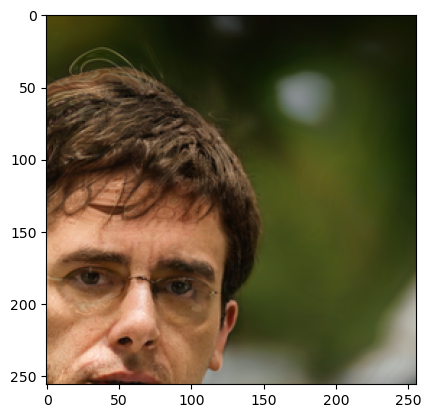

In [19]:
# show image

import matplotlib.pyplot as plt

plt.imshow((img.squeeze().permute(1, 2, 0).cpu().detach().numpy() + 1) / 2)